In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from scipy.stats import randint, expon, uniform

import sklearn as sk
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import RBF

from LoadData import load_data
import PlottingHelpers
import ProcessingHelpers

importlib.reload(ProcessingHelpers) # while still working on than fun
importlib.reload(PlottingHelpers) # while still working on than fun

<module 'PlottingHelpers' from '/home/jovyan/python-ml-turbofan/PlottingHelpers.py'>

In [2]:
sns.set() 

In [3]:
dirname = os.getcwd()
pth = os.path.join(dirname, 'CMAPSSData')

print('loading data...')
dc = load_data(pth)
print('done')

loading data...
done


In [4]:
# get the first data set training data
df = dc['FD_001']['df_train'].copy()

# Make a Column for the RUL target data (y)

According to the data description document the data set contains multiple units, each unit starts at a certain degradation point and the measurement data ends closely before the unit was decommissioned of broke. 

Therefore assume, that for the last measurement time that is available for a unit the units RUL=0 (stopped measuring just before machine broke)


In [5]:
# get the time of the last available measurement for each unit
mapper = {}
for unit_nr in df['unit_nr'].unique():
    mapper[unit_nr] = df['time'].loc[df['unit_nr'] == unit_nr].max()
    
# calculate RUL = time.max() - time_now for each unit
df['RUL'] = df['unit_nr'].apply(lambda nr: mapper[nr]) - df['time']

## Drop the nan columns and rows

In [6]:
cols_nan = df.columns[df.isna().any()].tolist()
print('Columns with all nan: \n' + str(cols_nan) + '\n')

cols_const = [ col for col in df.columns if len(df[col].unique()) <= 2 ]
print('Columns with all const values: \n' + str(cols_const) + '\n')

Columns with all nan: 
['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']

Columns with all const values: 
['os_3', 'sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']



In [7]:
df = df.drop(columns=cols_const + cols_nan)

## Normalize the dataset as shown in the Explorative_analysis notebook

In [8]:
df_start = df.loc[df['time'] < 10.0].copy()
cols_non_data = [col for col in df.columns if not col.startswith('sens')]
bias = df_start.mean()
scale = df_start.var()

bias[cols_non_data] = 0.0
scale[cols_non_data] = 1.0

df_n = (df - bias) / scale
#df_n = df.copy()

take out a certain percentage of units from the training data set for testing later, (additionally to the classic validation methods)


In [9]:
units = df_n['unit_nr'].unique()
n_units = len(df_n['unit_nr'].unique())

units_test = random.sample(list(units), int(n_units * 0.2))
units_train = [nr for nr in units if nr not in units_test]

df_n_test = df_n.loc[df_n['unit_nr'].apply( lambda x: x in units_test )].copy()
df_n_train = df_n.loc[df_n['unit_nr'].apply( lambda x: x in units_train )].copy()

In [10]:
df_n_train.describe()

,unit_nr,time,os_1,os_2,sensor_02,sensor_03,sensor_04,sensor_07,sensor_08,sensor_09,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
count,16156.000000,16156.000000,16156.000000,16156.000000,16156.000000,16156.000000,16156.000000,16156.000000,16156.000000,16156.000000,16156.000000,16156.000000,16156.000000,16156.000000,16156.000000,16156.000000,16156.000000,16156.000000,16156.000000
mean,51.417059,105.830465,-0.000004,-0.000003,2.169739,0.174375,0.180730,-1.470593,12.430329,0.141397,6.118964,-1.915724,12.809421,0.112955,33.711757,0.725080,-6.955617,-11.102167,104.830465
std,28.179653,65.985906,0.002182,0.000292,3.563843,0.286843,0.260059,2.207190,23.508092,0.319976,8.599275,2.772255,23.491913,0.310471,53.099440,1.167763,10.528970,16.787554,65.985906
min,1.000000,1.000000,-0.008700,-0.000600,-8.286161,-0.735588,-0.588925,-10.253492,-52.250101,-0.451162,-15.748875,-11.658664,-57.379848,-0.517978,-132.009789,-3.206230,-46.306977,-72.250329,0.000000
25%,28.000000,51.000000,-0.001500,-0.000300,-0.397437,-0.026001,-0.009219,-2.874627,-5.946031,-0.036250,0.008933,-3.645047,-5.107449,-0.061829,-4.767501,-0.192541,-13.737842,-21.625591,50.000000
50%,51.000000,101.000000,0.000000,0.000000,1.876790,0.155012,0.155916,-1.304126,10.591137,0.073026,5.475928,-1.688670,11.227676,0.060999,29.446536,0.560881,-6.177150,-9.935822,100.000000
75%,76.000000,153.000000,0.001500,0.000200,4.435295,0.355152,0.342704,0.141733,27.128306,0.199332,11.264510,0.117215,27.562801,0.183668,66.770940,1.314303,0.801950,0.872575,152.000000
max,100.000000,336.000000,0.008700,0.000600,15.308942,1.404371,1.121322,5.227167,166.040518,2.649302,37.956307,5.459627,164.777849,2.466147,235.437661,5.834836,28.718351,39.730231,335.000000


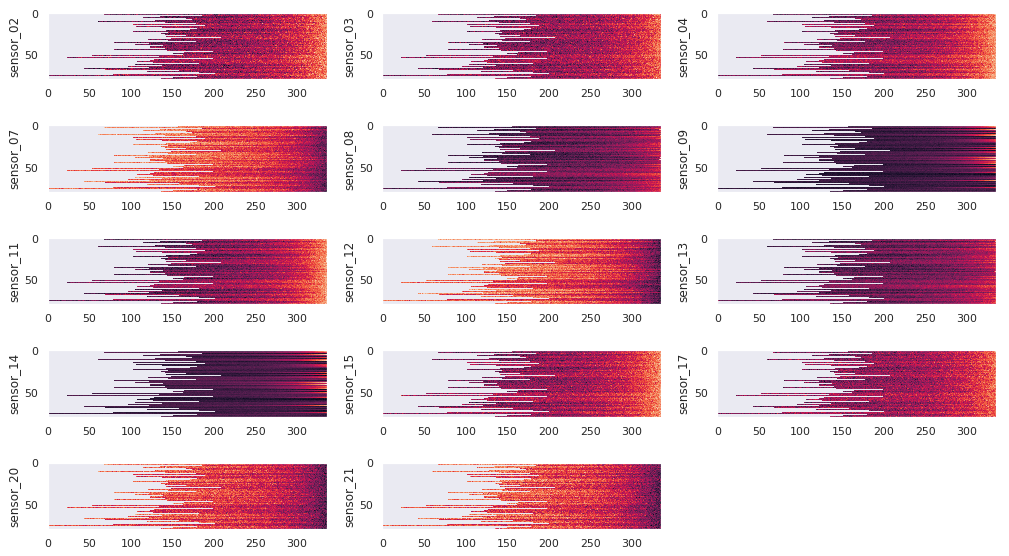

In [11]:
cols_features = [c for c in df_n_train.columns if c.startswith('o') or c.startswith('s')]

PlottingHelpers.plot_imshow(df_n_train, resample=False)


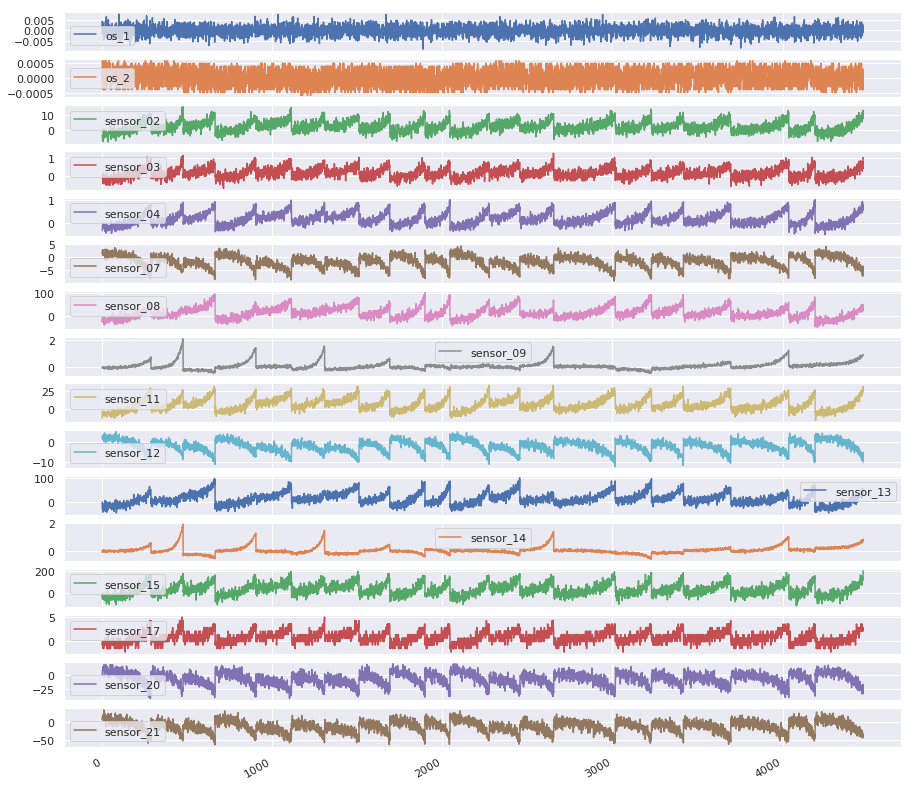

In [12]:
t = pd.DataFrame(df_n_test[cols_features].values, columns=cols_features).plot(subplots=True, figsize=(15, 15))

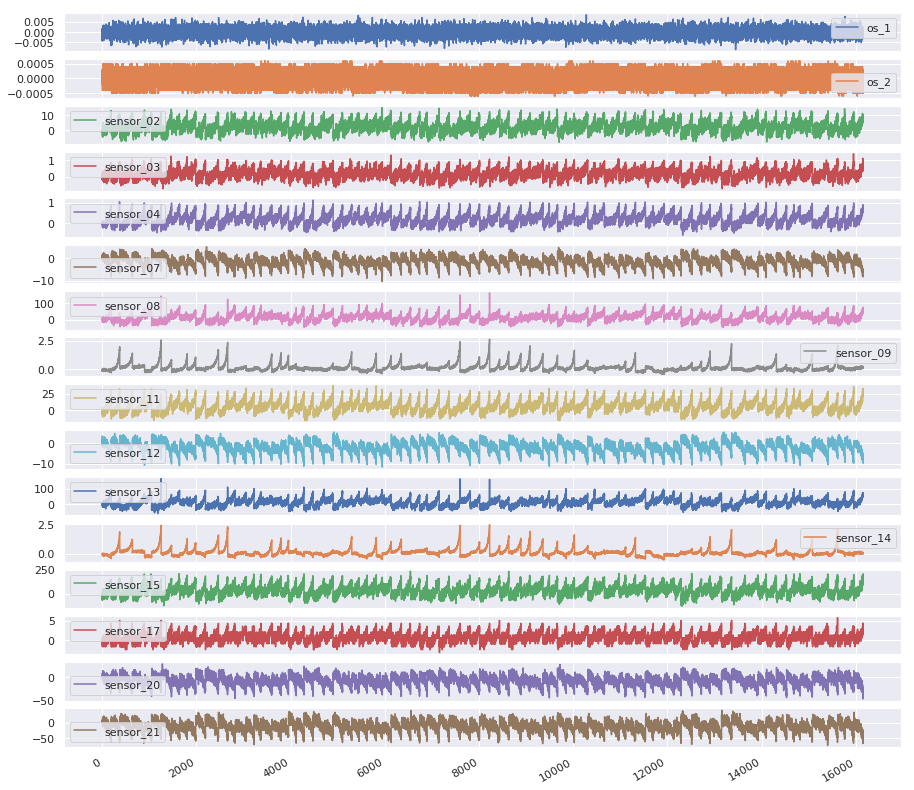

In [13]:
t = pd.DataFrame(df_n_train[cols_features].values, columns=cols_features).plot(subplots=True, figsize=(15, 15))

## Do a simple support vector machine based regression based on all training data

define a helper function for the simple fitting through a support vector machine

In [14]:
def fit_sub(df_n_train, df_n_test, mdl, cols_features):
    X_train = df_n_train[cols_features].values
    y_train = df_n_train['RUL'].values

    X_test = df_n_test[cols_features].values
    y_test = df_n_test['RUL'].values

    print(X_train.shape)
    if mdl is None:
        mdl = sk.pipeline.Pipeline([
            ('scaler', sk.preprocessing.MinMaxScaler()),
            ('regression', sk.svm.SVR(gamma='scale')),
        ])

    scoring = sk.metrics.mean_squared_error

    y_cv = sk.model_selection.cross_val_predict(
        mdl,
        X_train,
        y_train,
        cv=3,
    )

    mdl.fit(X_train, y_train)
    y_test_p = mdl.predict(X_test)


    scoring = sk.metrics.mean_squared_error

    print("cv test mse: %s" % scoring(y_cv, y_train))
    print("testing units mse: %s" % scoring(y_test_p, y_test))

    res_full = {
        'dy_train_cv': y_cv - y_train,
        'dy_test': y_test_p - y_test,
        'y_train_p_cv': y_cv,
        'y_test_p': y_test_p,
    }
    return res_full


def fit_and_test_clf(df_n_train, df_n_test, mdl=None, cols_features=None, subspace=True):
    
    if cols_features is None:
        cols_features = [c for c in df_n_train.columns if c.startswith('s')]

    res_full = fit_sub(df_n_train, df_n_test, mdl, cols_features)
    
    if not subspace:
        return res_full
    
    # Exclude the channels 14 and 9 since they are not generally falling or raising, 
    # and the channels 8,11,12,13,14 since they are highly correlating

    exclude = [ 'sensor_{}'.format(n) for n in ['08', '09', '11', '12', '13', '14'] ]
    cols_features2 = [c for c in cols_features if c.startswith('s') and c not in exclude]

    res_red = fit_sub(df_n_train, df_n_test, mdl, cols_features2)
    
    return res_full, res_red


In [15]:
res = {}

In [16]:
res_full, res_red = fit_and_test_clf(df_n_train, df_n_test, mdl=None, cols_features=None)
    
res['all_full'] = res_full
res['all_red'] = res_red

(16156, 14)
cv test mse: 1797.8900915631652
testing units mse: 2836.341050920603
(16156, 8)
cv test mse: 2032.491273853564
testing units mse: 3045.6696400332494


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


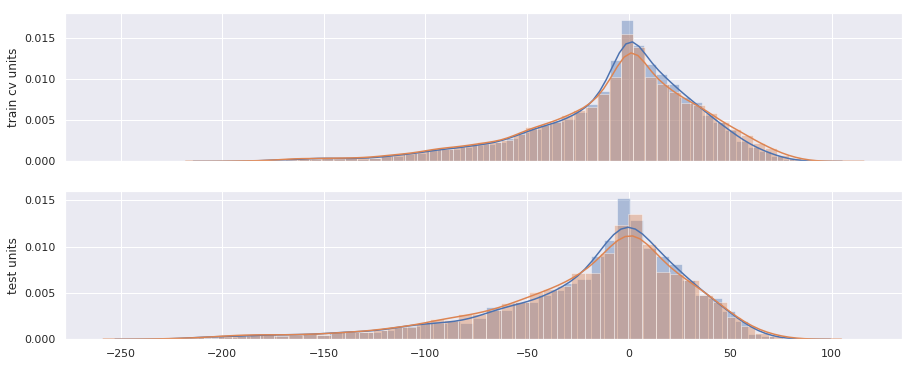

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
axes = axes.flatten()

for name, dc2 in res.items():
    sns.distplot(dc2['dy_train_cv'], ax=axes[0])
    sns.distplot(dc2['dy_test'], ax=axes[1])
    
lbl = axes[1].set_ylabel('test units')
lbl = axes[0].set_ylabel('train cv units')

the model(s) seems to converge, but the error distributions do not look very good, considering the fact, that some predictions are nearly 100 cycles off, while some units just have a life cylcle of about 125 cycles.

Lets take a look, how the regression values progress over the life cycle of each unit.

## Plot the progression of the predicted RULs over time:

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


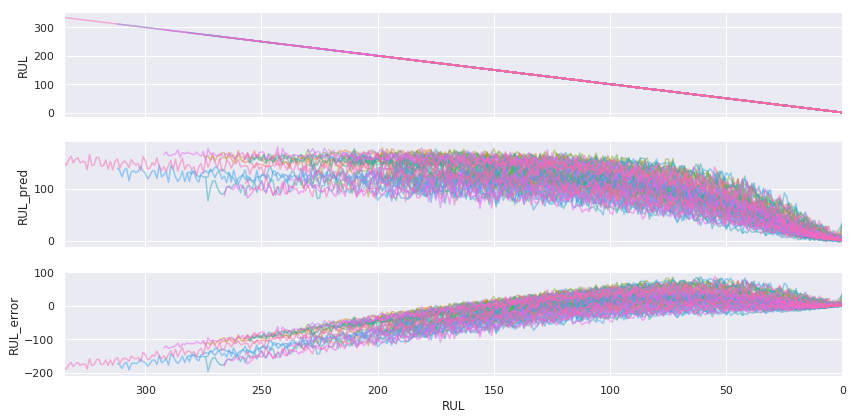

In [18]:
tmp = df_n_train[['RUL', 'unit_nr']]
tmp['RUL_error'] = res['all_full']['dy_train_cv']
tmp['RUL_pred'] = res['all_full']['y_train_p_cv']

PlottingHelpers.plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


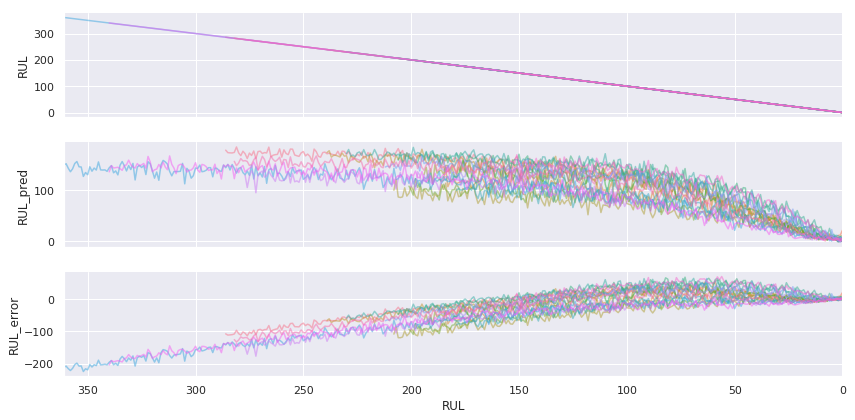

In [19]:
tmp = df_n_test[['RUL', 'unit_nr']]
tmp['RUL_error'] = res['all_full']['dy_test']
tmp['RUL_pred'] = res['all_full']['y_test_p']

PlottingHelpers.plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

The predicted RULs are especially off at the beginning of the life cycle of a unit, but seem to get closer the more a machine nears to the end of it's life. This is especially valuable, when it comes to protecting the unit from damage, or scheduling maintenance closely to a breakdown.

Looking at the predicted values it can also be seen, that different machines show differently high predictions 

One way to achieve that, would be to directly model the whole problem as a binary classification problem, another would be to simply thresthold the predicted RUL's by a thresthold value for the RUL. In order to robustify the model further against noise it can make sens to debounce the actual threstholding using a floating median filter.

## Do a quick inspection of a binary threstholding for the test data set results:

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(361.0, 0.0)

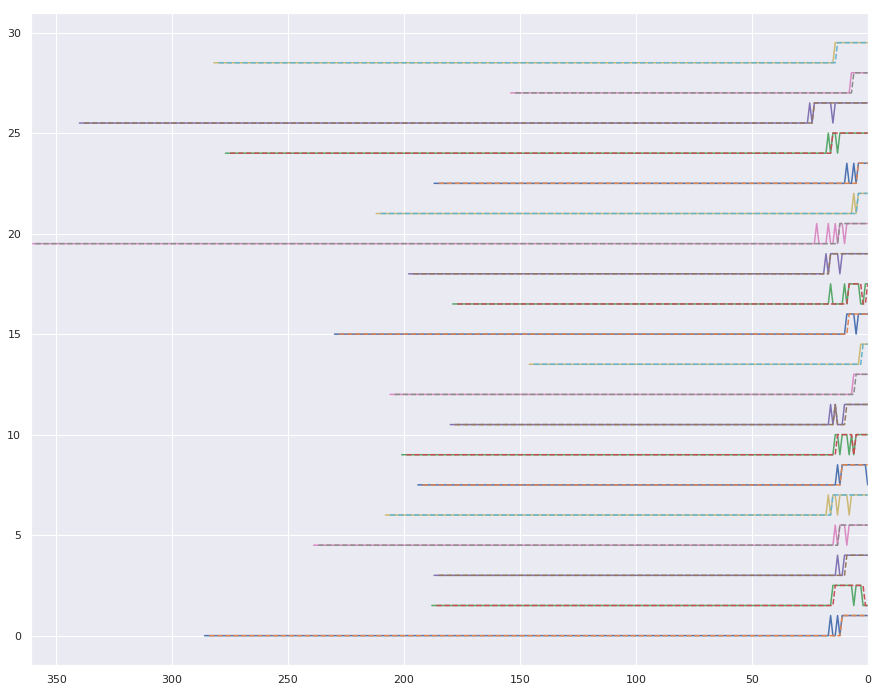

In [20]:
tmp = df_n_test[['RUL', 'unit_nr', 'time']]
tmp['FAILURE_NEAR'] = res['all_full']['y_test_p'] < 10.0

fig, ax = plt.subplots(1, 1, figsize=(15,12))

for i, (name, tmp2) in enumerate(tmp.groupby('unit_nr')):
    y = tmp2['FAILURE_NEAR'] + (i * 1.5)
    y_med = tmp2['FAILURE_NEAR'].rolling(3).median() + (i * 1.5)
     
    ax.plot(tmp2['RUL'].values, y)
    ax.plot(tmp2['RUL'].values, y_med, linestyle='--')
   
ax.set_xlim((df_n_test['RUL'].max(),df_n_test['RUL'].min()))

That looks promising, so lets investigate a bit further.


## define a mapping function to make the regressed values binary classifications:

In [21]:
def map_2_n_looks_ahead(df_loc, res_now, n_ahead = 10):
    tmp = df_loc[['RUL', 'unit_nr', 'time']]
    tmp['FAILURE_NEAR'] = res_now < n_ahead
    df_predictions = {
        'unit_nr': [],
        'FailureFoundAtEnd': [],
        'FailurePredictionError': [],
        'FailureFoundAtEndMedian': [],
        'FailurePredictionErrorMedian': []
    }

    for i, (name, tmp2) in enumerate(tmp.groupby('unit_nr')):
        wind_size = 3
        y = tmp2['FAILURE_NEAR'] * 1.0
        y_med = tmp2['FAILURE_NEAR'].rolling(wind_size).median()

        RUL_first = n_ahead - tmp2[y > 0].iloc[0]['RUL']
        RUL_first_med = n_ahead - np.ceil(wind_size/2) - tmp2[y_med > 0].iloc[0]['RUL']

        df_predictions['unit_nr'].append(name)
        df_predictions['FailureFoundAtEnd'].append(y.iloc[-1])
        df_predictions['FailurePredictionError'].append(RUL_first)
        df_predictions['FailureFoundAtEndMedian'].append(y_med.iloc[-1])
        df_predictions['FailurePredictionErrorMedian'].append(RUL_first_med)


    df_predictions = pd.DataFrame(df_predictions)
    df_predictions = df_predictions.set_index('unit_nr')
    return df_predictions

## Analyze if unit breakdowns are predicted properly for the cross validated data set

units with failure not found at end:
[4.0, 21.0]
units with failure not found at end (with median):
[4.0]

total number of units where failures are not found properly:
with median   : 1/20 (5.0%)
without median: 2/20 (10.0%)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


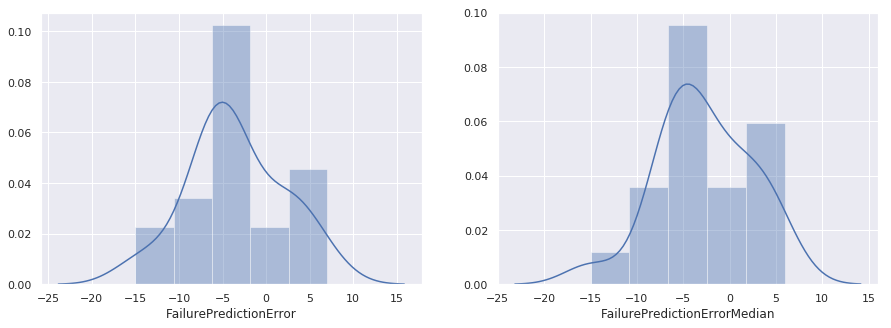

In [22]:
#a = df_predictions.plot.bar(figsize=(15,12), subplots=True)
df_predictions = map_2_n_looks_ahead(df_n_test, res['all_full']['y_test_p'])

yy = list(df_predictions[df_predictions['FailureFoundAtEnd'] == 0].index)
yy_med = list(df_predictions[df_predictions['FailureFoundAtEndMedian'] == 0].index)

print('units with failure not found at end:\n{}'.format(yy))
print('units with failure not found at end (with median):\n{}'.format(yy_med))
print('\ntotal number of units where failures are not found properly:')
print('with median   : {}/{} ({}%)'.format(len(yy_med), len(df_predictions), len(yy_med) / len(df_predictions) * 100))
print('without median: {}/{} ({}%)'.format(len(yy), len(df_predictions), len(yy) / len(df_predictions) * 100))

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes = axes.flatten()
sns.distplot(df_predictions['FailurePredictionError'], ax=axes[0])
sns.distplot(df_predictions['FailurePredictionErrorMedian'], ax=axes[1])

## Analyze if unit breakdowns are predicted properly for the testing data set

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


units with failure not found at end:
[3.0, 9.0, 18.0, 48.0, 51.0, 55.0, 82.0, 97.0]
units with failure not found at end (with median):
[3.0, 9.0, 18.0, 48.0, 51.0, 97.0]

total number of units where failures are not found properly:
with median   : 6/80 (7.5%)
without median: 8/80 (10.0%)


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


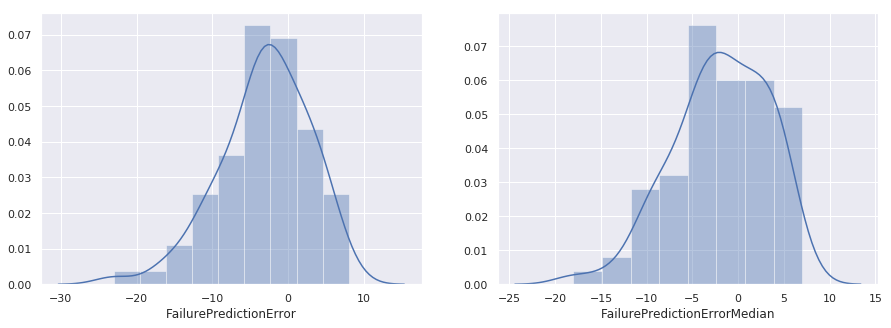

In [23]:
#a = df_predictions.plot.bar(figsize=(15,12), subplots=True)
df_predictions = map_2_n_looks_ahead(df_n_train, res['all_full']['y_train_p_cv'])

yy = list(df_predictions[df_predictions['FailureFoundAtEnd'] == 0].index)
yy_med = list(df_predictions[df_predictions['FailureFoundAtEndMedian'] == 0].index)

print('units with failure not found at end:\n{}'.format(yy))
print('units with failure not found at end (with median):\n{}'.format(yy_med))
print('\ntotal number of units where failures are not found properly:')
print('with median   : {}/{} ({}%)'.format(len(yy_med), len(df_predictions), len(yy_med) / len(df_predictions) * 100))
print('without median: {}/{} ({}%)'.format(len(yy), len(df_predictions), len(yy) / len(df_predictions) * 100))
              
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes = axes.flatten()
sns.distplot(df_predictions['FailurePredictionError'], ax=axes[0])
sns.distplot(df_predictions['FailurePredictionErrorMedian'], ax=axes[1])

Numbers > 0 predict a breakdown later than thought, while Numbers < 0 are predicting a breakdown earlier than thought. Values predicting breakdown too early are less problematic than values predicting a breakdown too late. 

Generally it looks like more than 90% of breakdowns are detected at least 1 cycle or more ahead of time. This is from a ML point of view only a mediocre result, which is not suprising considering the fact, that we just used an out of the box SVM for regression. We can do better, but it should be noted, that predicing a breakdown in time for more than 90% of the units in time is already a very practical thing when it comes to building a real condition monitoring systems. Especially considering the fact, that the given SVM model can be implemented very easily.



## Before moving to more complex models, lets try some other out of the box regression models:

In [24]:
res_arr = {}

In [25]:
models = {
    "SVM": sk.svm.SVR(gamma='scale'),
    "Nearest Neighbor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Neural Net": MLPRegressor(),
    'lr': sk.linear_model.LinearRegression(),
    'lasso': sk.linear_model.Lasso(alpha=.1),
    'Bridge': sk.linear_model.BayesianRidge(),
    #'Kridge': sk.kernel_ridge.KernelRidge(),
    'ridge': sk.linear_model.Ridge(),
    #'GBR': sk.ensemble.GradientBoostingRegressor(),
}

scoring = sk.metrics.mean_squared_error
for name, clf in models.items():
    
    print('\n=========================\n')
    
    if name in res_arr:
        print('skipping model because already found: ' + name )
        continue
        
    print('fitting model: ' + name )
    mdl = sk.pipeline.Pipeline([
        ('scaler', sk.preprocessing.MinMaxScaler()),
        ('regression', models[name]),
    ])
    
    res_full, res_red = fit_and_test_clf(df_n_train, df_n_test, mdl=mdl, cols_features=None)
    
    res_arr[name] = {
        'res_full': res_full,
        'res_red': res_red,
    }
    



fitting model: SVM
(16156, 14)
cv test mse: 1797.8900915631652
testing units mse: 2836.341050920603
(16156, 8)
cv test mse: 2032.491273853564
testing units mse: 3045.6696400332494


fitting model: Nearest Neighbor
(16156, 14)
cv test mse: 1966.347335974251
testing units mse: 2965.6719463687155
(16156, 8)
cv test mse: 2337.8345654865066
testing units mse: 3272.7561206703913


fitting model: Decision Tree
(16156, 14)
cv test mse: 3221.209952958653
testing units mse: 4237.928491620111
(16156, 8)
cv test mse: 3997.04499876207
testing units mse: 4851.612737430168


fitting model: Random Forest
(16156, 14)
cv test mse: 1717.5653959643475
testing units mse: 2618.817036960894
(16156, 8)
cv test mse: 2039.444204574152
testing units mse: 2940.379325005587


fitting model: Neural Net
(16156, 14)


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


cv test mse: 1690.0853568265206
testing units mse: 2652.8937509124016
(16156, 8)


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


cv test mse: 2023.8014296848517
testing units mse: 2811.9414935436776


fitting model: lr
(16156, 14)
cv test mse: 1857.4178344753773
testing units mse: 2725.525709261024
(16156, 8)
cv test mse: 2012.928316114998
testing units mse: 2842.678596194966


fitting model: lasso
(16156, 14)
cv test mse: 1856.2961683868564
testing units mse: 2741.4606220818014
(16156, 8)
cv test mse: 2012.9948376169887
testing units mse: 2859.9646593056555


fitting model: Bridge
(16156, 14)
cv test mse: 1857.2023928448084
testing units mse: 2725.796007114965
(16156, 8)
cv test mse: 2012.8894151230822
testing units mse: 2843.074205253686


fitting model: ridge
(16156, 14)
cv test mse: 1857.1865337107304
testing units mse: 2725.7611022807014
(16156, 8)
cv test mse: 2012.8852000938307
testing units mse: 2843.195159238268


In [26]:
def plt_helper(df_n, y_pred, ax):
    df_n_res = df_n[['RUL', 'unit_nr', 'time']].copy()
    df_n_res['RUL_pred'] = y_pred
    g = sns.relplot(x="RUL", y="RUL_pred", hue="unit_nr", kind="line", data=df_n_res, ax = ax)
    ax.set_xlim((df_n['RUL'].max(), df_n['RUL'].min()))

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'red test')

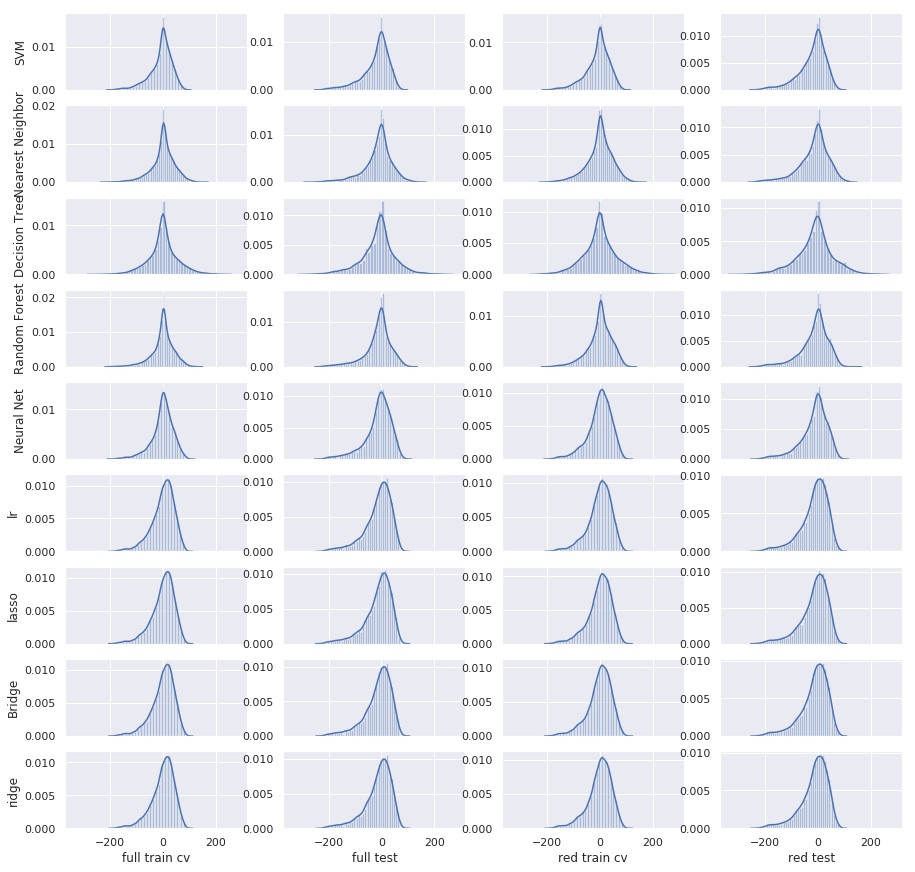

In [27]:
fig, axes = plt.subplots(len(res_arr), 4, figsize=(15, 15), sharex=True)
for i, (name, dc2) in enumerate(res_arr.items()):
    axes[i, 0].set_ylabel(name)
    sns.distplot(dc2['res_full']['dy_train_cv'], ax=axes[i, 0])
    sns.distplot(dc2['res_full']['dy_test'], ax=axes[i, 1])
    sns.distplot(dc2['res_red']['dy_train_cv'], ax=axes[i, 2])
    sns.distplot(dc2['res_red']['dy_test'], ax=axes[i, 3])
    
axes[-1, 0].set_xlabel('full train cv')
axes[-1, 1].set_xlabel('full test')
axes[-1, 2].set_xlabel('red train cv')
axes[-1, 3].set_xlabel('red test')

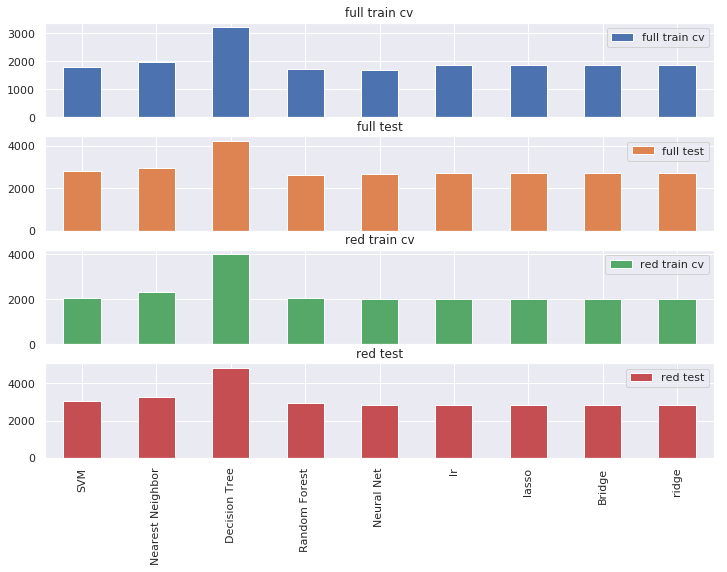

In [28]:
df_loc = pd.DataFrame(
{
    'full train cv': [np.mean(dc2['res_full']['dy_train_cv'] ** 2) for dc2 in res_arr.values()],
    'full test': [np.mean(dc2['res_full']['dy_test'] ** 2) for dc2 in res_arr.values()],
    'red train cv': [np.mean(dc2['res_red']['dy_train_cv'] ** 2) for dc2 in res_arr.values()],
    'red test': [np.mean(dc2['res_red']['dy_test'] ** 2) for dc2 in res_arr.values()],
}, index=res_arr.keys())  

axes = df_loc.plot.bar(subplots=True, figsize=(12, 8))


Ok, is looks like most models with exception of the Decision Tree model show about the same performance, lets try using a more complex Neural Net model before we go to more complex feature engineering and modelling:

## Fit a deeper more complex MLP Regressor model

In [33]:
mdl = sk.pipeline.Pipeline([
    ('scaler', sk.preprocessing.StandardScaler()),
    ('regression', MLPRegressor(hidden_layer_sizes=(100, 200, 200, 100),
                   alpha=0.01, 
                   solver='adam', 
                   random_state=0, 
                   max_iter=1000,
                   shuffle=True,
                   verbose=False,
                   activation='logistic')),
])


res = fit_and_test_clf(df_n_train, df_n_test, mdl=mdl, subspace=False)

(16156, 14)
cv test mse: 1684.8063663773055
testing units mse: 2566.9429615700074


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


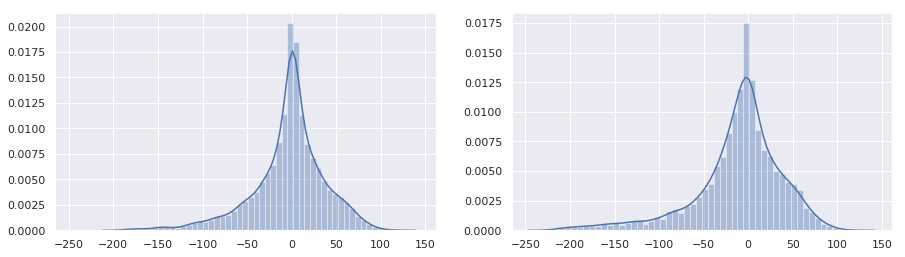

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharex=True)
sns.distplot(res['dy_train_cv'], ax=axes[0])
sns.distplot(res['dy_test'], ax=axes[1])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


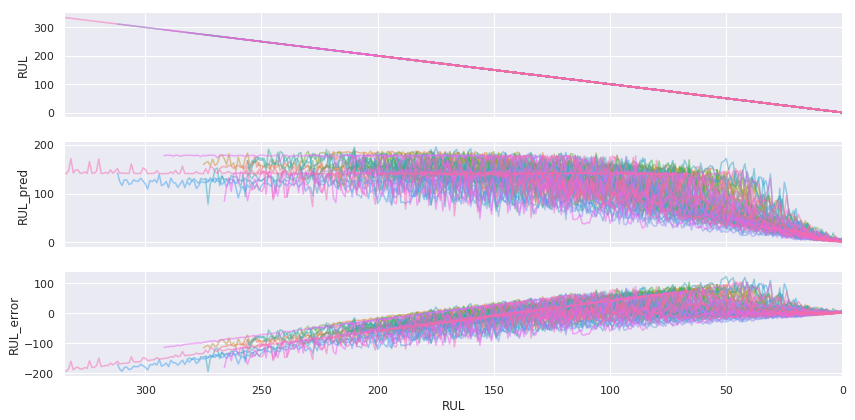

In [31]:
tmp = df_n_train[['RUL', 'unit_nr']]
tmp['RUL_error'] = res['dy_train_cv']
tmp['RUL_pred'] = res['y_train_p_cv']

PlottingHelpers.plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


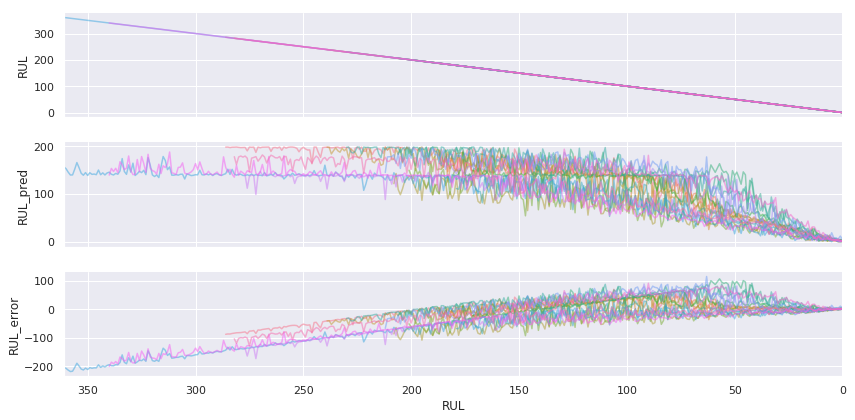

In [32]:
tmp = df_n_test[['RUL', 'unit_nr']]
tmp['RUL_error'] = res['dy_test']
tmp['RUL_pred'] = res['y_test_p']

PlottingHelpers.plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])